High-risk pixels (threshold=0.60): 6349/10249 (61.9%)


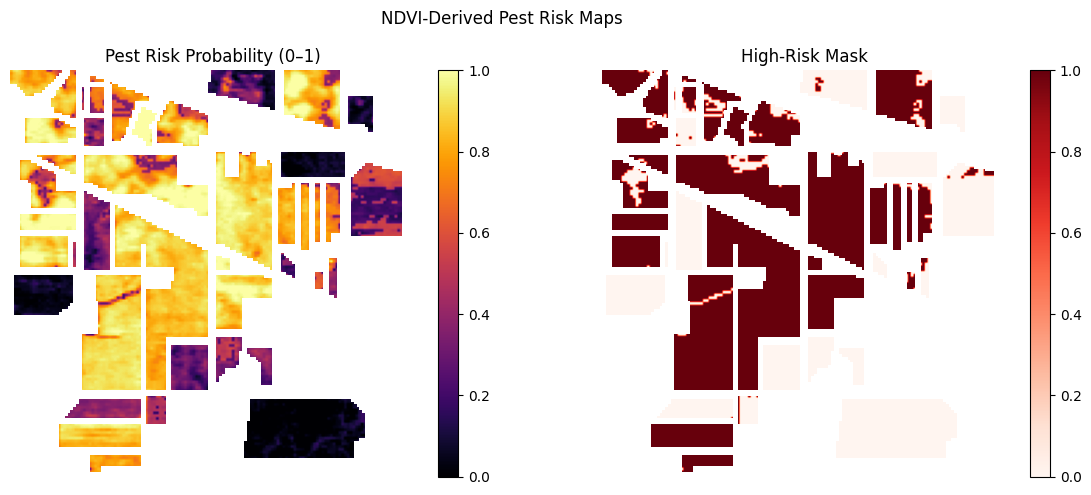

Saved figure: outputs\pest_risk_maps.png
Saved arrays in: outputs


In [1]:
# ==========================================
# Local VS Code: NDVI-Derived Pest Risk Maps
# ==========================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

# 1) Helpers
def ensure_outdir(path="outputs"):
    os.makedirs(path, exist_ok=True)
    return path

def compute_ndvi_from_cube(cube, red_idx=28, nir_idx=79, mask=None):
    eps = 1e-6
    red = cube[:, :, red_idx].astype(np.float64)
    nir = cube[:, :, nir_idx].astype(np.float64)
    ndvi = (nir - red) / (nir + red + eps)
    if mask is not None:
        ndvi = ndvi.copy()
        ndvi[~mask] = np.nan
    return ndvi

def ndvi_to_risk(ndvi_map, p_low=5, p_high=95):
    eps = 1e-6
    valid = ~np.isnan(ndvi_map)
    vals = ndvi_map[valid]
    if vals.size == 0: raise ValueError("No valid NDVI values.")
    p5, p95 = np.percentile(vals, [p_low, p_high])
    ndvi_norm = (ndvi_map - p5) / (p95 - p5 + eps)
    ndvi_norm = np.clip(ndvi_norm, 0.0, 1.0)
    risk_prob = 1.0 - ndvi_norm
    risk_prob[~valid] = np.nan
    return risk_prob

def optional_sensor_scalar_from_csv(csv_path):
    try:
        if not os.path.isfile(csv_path): return None
        df = pd.read_csv(csv_path)
        cols = [c for c in df.columns if c.lower() in
                ["soilmoisture","humidity","temp","temperature","leafwetness"]]
        if not cols: return None
        zlist = []
        for c in cols:
            s = df[c].astype(float)
            z = (s - s.mean()) / (s.std() + 1e-6)
            if c.lower() == "soilmoisture": z = -z
            zlist.append(z.values)
        if not zlist: return None
        zstack = np.vstack([z for z in zlist if np.all(np.isfinite(z))])
        if zstack.size == 0: return None
        mean_z = float(np.nanmean(zstack))
        stress_scalar = 1.0 / (1.0 + np.exp(-mean_z))
        return float(np.clip(stress_scalar, 0.0, 1.0))
    except Exception:
        return None

def fuse_risk_with_sensor(risk_prob, stress_scalar, alpha=0.7):
    if stress_scalar is None: return risk_prob
    fused = alpha * risk_prob + (1.0 - alpha) * stress_scalar
    fused[np.isnan(risk_prob)] = np.nan
    return np.clip(fused, 0.0, 1.0)

def summarize_high_risk(risk_prob, thr=0.6):
    valid = ~np.isnan(risk_prob)
    high = (risk_prob >= thr) & valid
    num_valid = int(valid.sum())
    num_high = int(high.sum())
    pct = 100.0 * (num_high / max(1, num_valid))
    return num_high, num_valid, pct

def show_and_save_maps(risk_prob, risk_mask, outdir="outputs",
                       cmap_prob="inferno", cmap_mask="Reds"):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    h1 = plt.imshow(risk_prob, cmap=cmap_prob, vmin=0, vmax=1)
    plt.title("Pest Risk Probability (0–1)"); plt.axis('off')
    plt.colorbar(h1, fraction=0.046, pad=0.04)
    plt.subplot(1, 2, 2)
    h2 = plt.imshow(risk_mask, cmap=cmap_mask, vmin=0, vmax=1)
    plt.title("High-Risk Mask"); plt.axis('off')
    plt.colorbar(h2, fraction=0.046, pad=0.04)
    plt.suptitle("NDVI-Derived Pest Risk Maps")
    plt.tight_layout()
    png_path = os.path.join(outdir, "pest_risk_maps.png")
    plt.savefig(png_path, dpi=200, bbox_inches="tight")
    plt.show()
    print(f"Saved figure: {png_path}")

# ----------------------------
# 2) Paths for local files
# ----------------------------
crt_path = r"C:\sih\Indian_pines_corrected.mat"
gt_path  = r"C:\sih\Indian_pines_gt.mat"
sensor_csv_path = None   # Optional: r"C:\sih\sensor_readings.csv"

# ----------------------------
# 3) Load data
# ----------------------------
crt = loadmat(crt_path)
gt  = loadmat(gt_path)
cube = crt["indian_pines_corrected"]
y    = gt["indian_pines_gt"]
assert cube.ndim == 3 and y.ndim == 2 and cube.shape[:2] == y.shape, "Shape mismatch"

# ----------------------------
# 4) NDVI -> Risk
# ----------------------------
OUTDIR = ensure_outdir("outputs")
RED_IDX, NIR_IDX = 28, 79
mask_valid = (y != 0)
ndvi_map = compute_ndvi_from_cube(cube, RED_IDX, NIR_IDX, mask=mask_valid)
risk_prob = ndvi_to_risk(ndvi_map, p_low=5, p_high=95)

# ----------------------------
# 5) Optional sensor fusion
# ----------------------------
stress_scalar = optional_sensor_scalar_from_csv(sensor_csv_path) if sensor_csv_path else None
if stress_scalar is not None:
    print(f"Fusing sensor-derived stress scalar: {stress_scalar:.3f}")
risk_prob_fused = fuse_risk_with_sensor(risk_prob, stress_scalar, alpha=0.7)

# ----------------------------
# 6) Threshold and stats
# ----------------------------
RISK_THRESHOLD = 0.6
risk_mask = np.full_like(risk_prob_fused, np.nan)
valid = ~np.isnan(risk_prob_fused)
risk_mask[valid] = (risk_prob_fused[valid] >= RISK_THRESHOLD).astype(float)
num_high, num_valid, pct = summarize_high_risk(risk_prob_fused, RISK_THRESHOLD)
print(f"High-risk pixels (threshold={RISK_THRESHOLD:.2f}): {num_high}/{num_valid} ({pct:.1f}%)")

# ----------------------------
# 7) Visualize and save
# ----------------------------
show_and_save_maps(risk_prob_fused, risk_mask, outdir=OUTDIR)
np.save(os.path.join(OUTDIR, "ndvi_map.npy"), ndvi_map)
np.save(os.path.join(OUTDIR, "risk_prob.npy"), risk_prob_fused)
np.save(os.path.join(OUTDIR, "risk_mask.npy"), risk_mask)
print(f"Saved arrays in: {OUTDIR}")


In [2]:
# %% 
# --- SAVE NDVI, Risk Probabilities, Risk Mask, and Optional Sensor Scalar USING PICKLE ---
import pickle

# Paths for saving
ndvi_file      = os.path.join(OUTDIR, "ndvi_map.pkl")
risk_prob_file = os.path.join(OUTDIR, "risk_prob.pkl")
risk_mask_file = os.path.join(OUTDIR, "risk_mask.pkl")
sensor_file    = os.path.join(OUTDIR, "stress_scalar.pkl")

# Save NDVI map
with open(ndvi_file, 'wb') as f:
    pickle.dump(ndvi_map, f)

# Save risk probabilities
with open(risk_prob_file, 'wb') as f:
    pickle.dump(risk_prob_fused, f)

# Save risk mask
with open(risk_mask_file, 'wb') as f:
    pickle.dump(risk_mask, f)

# Save sensor scalar (if exists)
if stress_scalar is not None:
    with open(sensor_file, 'wb') as f:
        pickle.dump(stress_scalar, f)

print(f"NDVI, Risk maps, and Sensor scalar saved as .pkl in {OUTDIR}")


NDVI, Risk maps, and Sensor scalar saved as .pkl in outputs
